In [1]:
import pandas as pd
from pandas import DataFrame
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime, timedelta
from statsmodels.tsa.arima_model import ARIMA
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.seasonal import seasonal_decompose
from scipy import stats
import statsmodels.api as sm
from itertools import product
from math import sqrt
from sklearn.metrics import mean_squared_error 

import warnings
warnings.filterwarnings('ignore')

%matplotlib inline

colors = ["windows blue", "amber", "faded green", "dusty purple"]
sns.set(rc={"figure.figsize": (20,10), "axes.titlesize" : 18, "axes.labelsize" : 12, 
            "xtick.labelsize" : 14, "ytick.labelsize" : 14 })

C:\ProgramData\Anaconda2\lib\site-packages\statsmodels\compat\pandas.py:56: FutureWarning: The pandas.core.datetools module is deprecated and will be removed in a future version. Please use the pandas.tseries module instead.
  from pandas.core import datetools


In [2]:
dateparse = lambda dates: pd.datetime.strptime(dates, '%Y-%m-%d')
df = pd.read_csv('predict_stockAPPLE.csv', parse_dates=['Date'], index_col='Date', date_parser=dateparse)
df = df.loc[:, ~df.columns.str.contains('^Unnamed')]

In [5]:
df.sample(10)

,Open,High,Low,Close,Volume,Dividend,Split,Adj_Open,Adj_High,Adj_Low,Adj_Close,Adj_Volume
Date,,,,,,,,,,,,
1986-07-01,35.88,36.13,34.75,35.380,391600.0,0.0,1.0,0.519686,0.523307,0.503319,0.512444,21929600.0
2002-06-06,22.96,23.23,22.04,22.160,4642800.0,0.0,1.0,1.453384,1.470476,1.395148,1.402744,64999200.0
2016-04-26,103.91,105.30,103.91,104.350,56016165.0,0.0,1.0,99.430871,100.760953,99.430871,99.851904,56016165.0
2008-04-30,176.26,180.00,172.92,173.950,40697300.0,0.0,1.0,22.314768,22.788258,21.891920,22.022319,284881100.0
1981-05-14,27.13,27.13,26.87,26.870,22000.0,0.0,1.0,0.392951,0.392951,0.389185,0.389185,1232000.0
1995-10-20,35.25,35.25,34.63,35.130,3449400.0,0.0,1.0,1.112220,1.112220,1.092658,1.108434,96583200.0
2013-06-07,436.50,443.24,432.77,441.811,14447700.0,0.0,1.0,56.451042,57.322703,55.968654,57.137895,101133900.0
1986-02-05,23.75,23.87,23.50,23.750,880200.0,0.0,1.0,0.343995,0.345733,0.340374,0.343995,49291200.0
1991-03-05,59.00,63.25,59.00,63.130,3941500.0,0.0,1.0,1.770090,1.897596,1.770090,1.893996,110362000.0


In [6]:
# Extract the bitcoin data only
btc=df
# Drop some columns
btc.drop(['Dividend','Split','Adj_Open','Adj_High','Adj_Low','Adj_Close','Adj_Volume'],axis=1,inplace=True) 

In [7]:
# Resampling to monthly frequency
btc_month = btc.resample('M').mean()

Dickey–Fuller test: p=0.480055


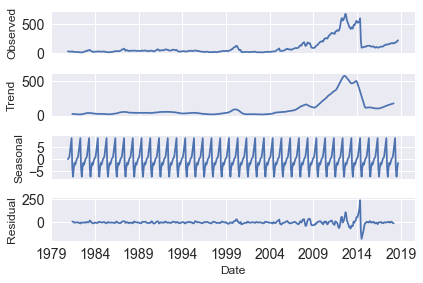

In [8]:
#seasonal_decompose(btc_month.close, freq=12).plot()
seasonal_decompose(btc_month.Close, model='additive').plot()
print("Dickey–Fuller test: p=%f" % adfuller(btc_month.Close)[1])

In [ ]:
#The p-value indicates that series is not stationary with 48.00% confidence.

#Most interesting is the seasonal component which was extracted, which looks like it repeats itself on a yearly basis.

#We can also see that the residuals are fairly constant until around the start of 2017, which is going to make forecasting difficult as we are still inside of this time period where the price is moving insanely.

#However, lets proceed anyway.

In [ ]:
#Box-Cox Transformation
#Lets use the Box-Cox transformation to suppress some of the variance.

#The Box-Cox transformation is a family of power transformations indexed by a parameter lambda. 
#Whenever you use it the parameter needs to be estimated from the data. In time series the process could have a
#non-constant variance. if the variance changes with time the process is nonstationary. 
#It is often desirable to transform a time series to make it stationary. Sometimes after applying Box-Cox with 
#a particular value of lambda the process may look stationary. It is sometimes possible that even if after applying 
#the Box-Cox transformation the series does not appear to be stationary, diagnostics from ARIMA modeling can then be 
#used to decide if differencing or seasonal differencing might be useful to to remove polynomial trends or seasonal trends 
#respectively. After that the result might be an ARMA model that is stationary. If diagnostics confirm the orders p an q for 
#the ARMA model, the AR and MA parameters can then be estimated.

In [9]:
# Box-Cox Transformations
btc_month['close_box'], lmbda = stats.boxcox(btc_month.Close)
print("Dickey–Fuller test: p=%f" % adfuller(btc_month.close_box)[1])

Dickey–Fuller test: p=0.248951


In [ ]:
#The p-value indicates that series is still not stationary

In [ ]:
#Differencing
#When building models to forecast time series data (like ARIMA), another pre-processing step is 
#differencing the data (calculating sequentially xt−xt−1) until we get to a point where the series is stationary.
#Models account for oscillations but not for trends, and therefore, accounting for trends by differencing allows us 
#to use the models that account for oscillations.

#Once the model has been constructed, we can account for trends separately, by adding the trends component-wise.

In [ ]:
#Seasonal differentiation 
#One method of differencing data is seasonal differencing, which involves computing the difference
#between an observation and the corresponding observation in the previous year.

In [10]:
# Seasonal differentiation (12 months)
btc_month['box_diff_seasonal_12'] = btc_month.close_box - btc_month.close_box.shift(12)
print("Dickey–Fuller test: p=%f" % adfuller(btc_month.box_diff_seasonal_12[12:])[1])

Dickey–Fuller test: p=0.000094


In [ ]:
#The p-value indicates that series is stationary.

In [11]:
# Seasonal differentiation (3 months)
btc_month['box_diff_seasonal_3'] = btc_month.close_box - btc_month.close_box.shift(3)
print("Dickey–Fuller test: p=%f" % adfuller(btc_month.box_diff_seasonal_3[3:])[1])

Dickey–Fuller test: p=0.000000


In [ ]:
#The p-value indicates that series is stationary as the computed p-value is lower than the significance level alpha = 0.05.

In [ ]:
#Regular differentiation 
#Sometimes it may be necessary to difference the data a second time to obtain a stationary time series,
#which is referred to as second order differencing.

Dickey–Fuller test: p=0.000000


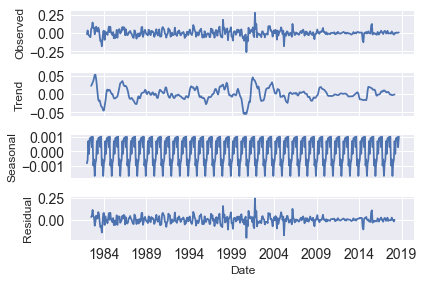

In [12]:
# Regular differentiation
btc_month['box_diff2'] = btc_month.box_diff_seasonal_12 - btc_month.box_diff_seasonal_12.shift(1)

# STL-decomposition
seasonal_decompose(btc_month.box_diff2[13:]).plot()   
print("Dickey–Fuller test: p=%f" % adfuller(btc_month.box_diff2[13:])[1])

In [ ]:
#The p-value indicates that series is stationary as the computed p-value is lower than the significance level alpha = 0.05.

In [ ]:
#Autocorrelation 
#Autocorrelation is the correlation of a time series with the same time series lagged. 
#It summarizes the strength of a relationship with an observation in a time series with observations at prior time steps.

#We create autocorrelation factor (ACF) and partial autocorrelation factor (PACF) plots to identify patterns 
#in the above data which is stationary on both mean and variance. The idea is to identify presence of AR and MA components
#in the residuals.

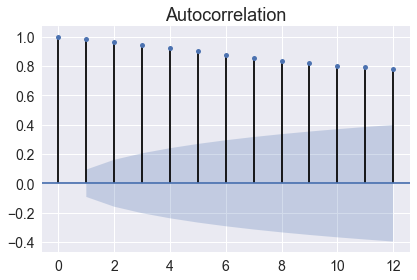

In [13]:
#autocorrelation_plot(btc_month.close)
plot_acf(btc_month.Close[13:].values.squeeze(), lags=12)
plt.tight_layout()

In [ ]:
#segun el guia
#There is a positive correlation with the first 10 lags that is perhaps significant for the first 2-3 lags.

#A good starting point for the AR parameter of the model may be 3.

#Lets try out autocorrelation on the differences...

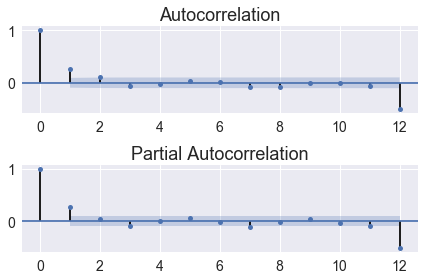

In [14]:
# Initial approximation of parameters using Autocorrelation and Partial Autocorrelation Plots
ax = plt.subplot(211)
# Plot the autocorrelation function
#sm.graphics.tsa.plot_acf(btc_month.box_diff2[13:].values.squeeze(), lags=48, ax=ax)
plot_acf(btc_month.box_diff2[13:].values.squeeze(), lags=12, ax=ax)
ax = plt.subplot(212)
#sm.graphics.tsa.plot_pacf(btc_month.box_diff2[13:].values.squeeze(), lags=48, ax=ax)
plot_pacf(btc_month.box_diff2[13:].values.squeeze(), lags=12, ax=ax)
plt.tight_layout()

In [ ]:
#There are not many spikes in the plots outside the insignificant zone (shaded) so there may not be enough information available in the residuals to be extracted by AR and MA models.

#There may be a seasonal component available in the residuals at the lags of quarters (3 months) represented by spikes at these intervals. But probably not significant.

In [ ]:
#Monthly Forecasting ¶
#ARIMA Model 
#AutoRegressive Integrated Moving Average

#ARIMA models are denoted with the notation ARIMA(p, d, q). These parameters account for seasonality, trend, and noise in datasets:

#p - the number of lag observations to include in the model, or lag order. (AR)
#d - the number of times that the raw observations are differenced, or the degree of differencing. (I)
#q - the size of the moving average window, also called the order of moving average.(MA)

#A linear regression model is constructed including the specified number and type of terms, and the data is prepared by a degree of differencing in order to make it stationary, i.e. to remove trend and seasonal structures that negatively affect the regression model. A value of 0 for a parameter indicates to not use that element of the model.

In [ ]:
#Parameter Selection
#We will iteratively explore different combinations of parameters. For each combination we fit a new ARIMA model with SARIMAX() and assess its overall quality.

#We will use the AIC (Akaike Information Criterion) value, returned with ARIMA models fitted using statsmodels. The AIC measures how well a model fits the data while taking into account the overall complexity of the model. A model that fits the data very well while using lots of features will be assigned a larger AIC score than a model that uses fewer features to achieve the same goodness-of-fit. Therefore, we are interested in finding the model that yields the lowest AIC value.

In [15]:
# Initial approximation of parameters
qs = range(0, 3)
ps = range(0, 3)
d=1
parameters = product(ps, qs)
parameters_list = list(parameters)
len(parameters_list)

# Model Selection
results = []
best_aic = float("inf")
warnings.filterwarnings('ignore')
for param in parameters_list:
    try:
        model = SARIMAX(btc_month.close_box, order=(param[0], d, param[1])).fit(disp=-1)
    except ValueError:
        print('bad parameter combination:', param)
        continue
    aic = model.aic
    if aic < best_aic:
        best_model = model
        best_aic = aic
        best_param = param
    results.append([param, model.aic])

('bad parameter combination:', (0, 0))
('bad parameter combination:', (2, 1))


In [ ]:
#Note that some parameter combinations may lead to numerical misspecifications and we explicitly disabled warning messages in order to avoid an overload of warning messages. These misspecifications can also lead to errors and throw an exception, so we catch these exceptions and just print out the parameter combinations that cause these issues.

In [16]:
# Best Models
result_table = pd.DataFrame(results)
result_table.columns = ['parameters', 'aic']
print(result_table.sort_values(by = 'aic', ascending=True).head())

  parameters          aic
1     (0, 2) -1854.945570
2     (1, 0) -1854.662095
5     (2, 0) -1853.276674
4     (1, 2) -1853.200479
3     (1, 1) -1853.036381


In [ ]:
#Note the AICs are negative but this is not a problem.

#Usually, AIC is positive; however, it can be shifted by any additive constant, and some shifts can result in negative values of AIC. [...] It is not the absolute size of the AIC value, it is the relative values over the set of models considered, and particularly the differences between AIC values, that are important.

#Ref: Model Selection and Multi-model Inference: A Practical Information-theoretic Approach (Burnham and Anderson, 2004)

In [17]:
print(best_model.summary())

                           Statespace Model Results                           
Dep. Variable:              close_box   No. Observations:                  454
Model:               SARIMAX(0, 1, 2)   Log Likelihood                 930.473
Date:                Thu, 27 Sep 2018   AIC                          -1854.946
Time:                        05:29:33   BIC                          -1842.591
Sample:                    12-31-1980   HQIC                         -1850.078
                         - 09-30-2018                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ma.L1          0.2299      0.038      6.107      0.000       0.156       0.304
ma.L2          0.1087      0.035      3.103      0.002       0.040       0.177
sigma2         0.0010   2.39e-05     40.227      0.0

In [18]:
print("Dickey–Fuller test:: p=%f" % adfuller(best_model.resid[13:])[1])

Dickey–Fuller test:: p=0.000000


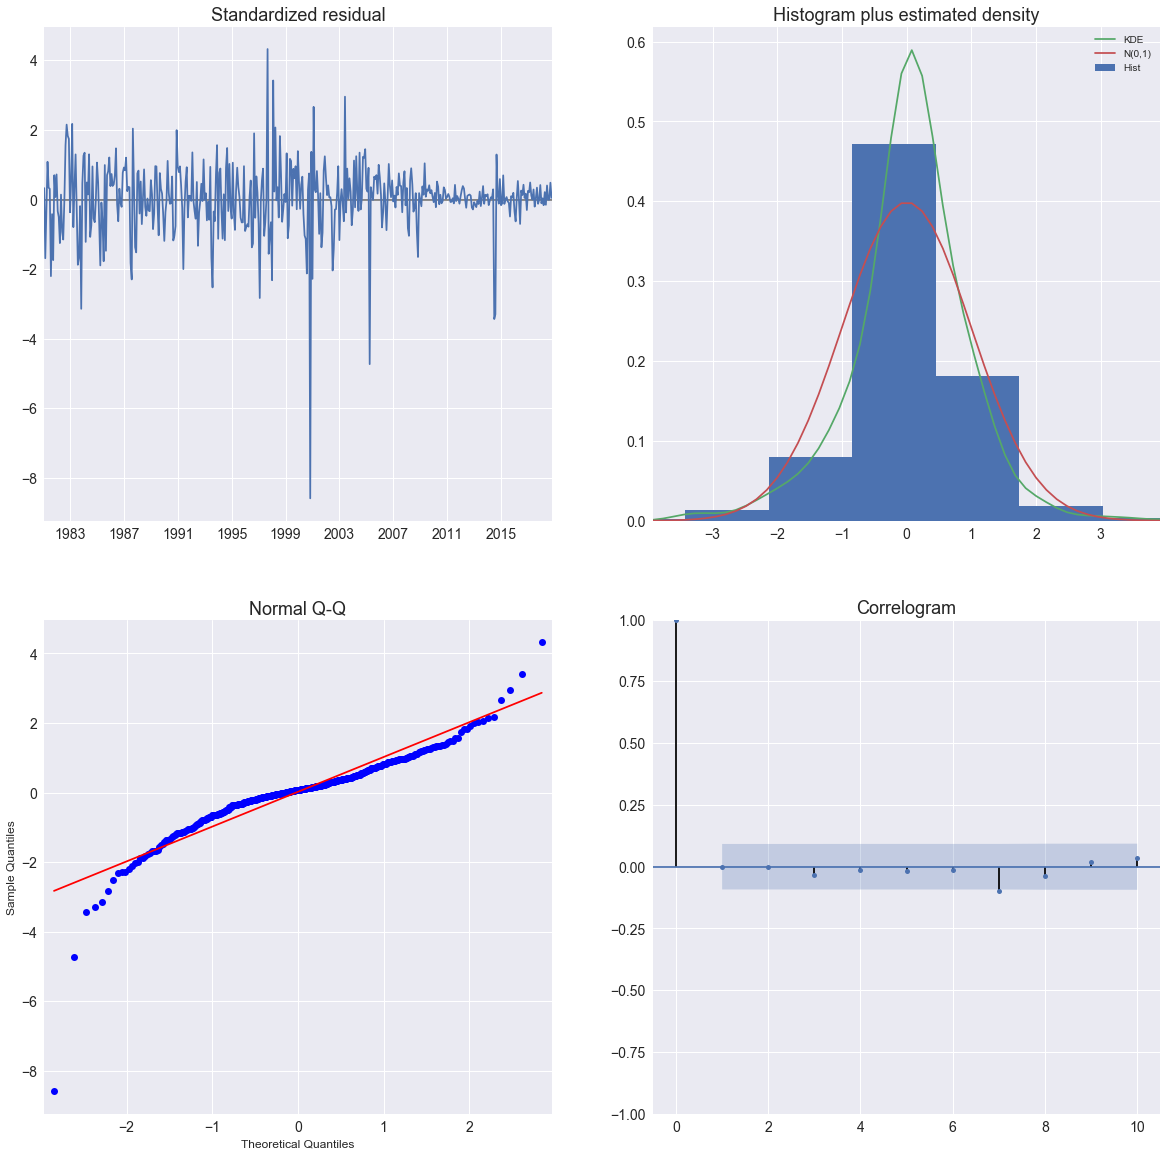

In [23]:
best_model.plot_diagnostics(figsize=(20, 20))
plt.show()

In [24]:
# Inverse Box-Cox Transformation Function
def invboxcox(y,lmbda):
   if lmbda == 0:
      return(np.exp(y))
   else:
      return(np.exp(np.log(lmbda*y+1)/lmbda))

Text(0,0.5,u'USD')

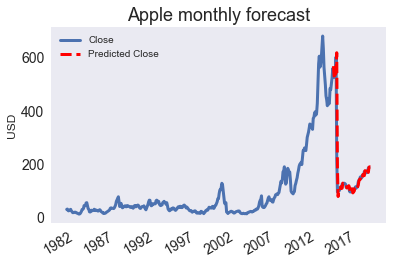

In [25]:
# Prediction
btc_month_pred = btc_month[['Close']]
date_list = [datetime(2018, 6, 30), datetime(2018, 7, 31), datetime(2018, 8, 31)]
future = pd.DataFrame(index=date_list, columns= btc_month.columns)
btc_month_pred = pd.concat([btc_month_pred, future])

#btc_month_pred['forecast'] = invboxcox(best_model.predict(start=0, end=75), lmbda)
btc_month_pred['forecast'] = invboxcox(best_model.predict(start=datetime(2014, 1, 31), end=datetime(2018, 8, 31)), lmbda)

btc_month_pred.Close.plot(linewidth=3)
btc_month_pred.forecast.plot(color='r', ls='--', label='Predicted Close', linewidth=3)
plt.legend()
plt.grid()
plt.title('Apple monthly forecast')
plt.ylabel('USD')